In [1]:
%pip install langgraph
%pip install langchain-openai
%pip install python-dotenv
%pip install langchain-community

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
#import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
#from langchain_openai import ChatOpenAI
from langchain_community.llms import Ollama
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

#from dotenv import load_dotenv

In [3]:
# Carregar variáveis de ambiente
#load_dotenv()

# Configurar a chave da API do OpenAI
#os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

In [14]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str

#llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm = Ollama(model="gemma2")

In [19]:
def classification_node(state: State):
    ''' Classifica o texto em uma das categorias: Notícias, Blog, Pesquisa ou Outro '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classifique o seguinte texto em uma das categorias: Notícias, Blog, Pesquisa ou Outro.\n\nTexto:{text}\n\nCategoria:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    classification = llm.invoke([message]).strip()
    return {"classification": classification}


def entity_extraction_node(state: State):
    ''' Extrai todas as entidades (Pessoa, Organização, Local) do texto '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extraia todas as entidades (Pessoa, Organização, Local) do seguinte texto. Forneça o resultado como uma lista separada por vírgulas.\n\nTexto:{text}\n\nEntidades:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    entities = llm.invoke([message]).strip().split(", ")
    return {"entities": entities}


def summarization_node(state: State):
    ''' Resume o texto em uma frase curta '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Resuma o seguinte texto em uma frase curta.\n\nTexto:{text}\n\nResumo:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary = llm.invoke([message]).strip()
    return {"summary": summary}

In [20]:
workflow = StateGraph(State)

# Adicionar nós ao grafo
workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)

# Adicionar arestas ao grafo
workflow.set_entry_point("classification_node") # Definir o ponto de entrada do grafo
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization")
workflow.add_edge("summarization", END)

# Compilar o grafo
app = workflow.compile()

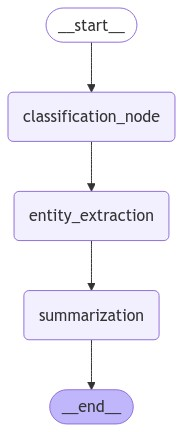

In [21]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [22]:
sample_text = """
Post do Linkedin Influencer Samuel Fernando: Quase todos os dias eu recebo mensagem com perguntas do que eu recomendo de cursos e formação em GenAI/LLM.

Eu tenho uma opinião muito forte sobre todos os cursos, imersões e essas coisas de "formação de IA para executivos" oferecidos por influenciadores famosos, escolas de negócios e plataformas de cursos. Costumo chamar de oba-oba. 

Portanto, eu, Samuel, que estudo, trabalho, pesquiso e divulgo IA desde 2016, NUNCA RECOMENDO. Se quiser eu explico meus motivos. IA Generativa é um assunto ultraespecializado com técnicas, papers e ferramentas recentes surgindo diariamente. Mas não é só isso. 

Entretanto, agora temos o Scoras Academy para recomendar com trilhas avançadas de assuntos e técnicas emergentes usadas em IA: SLMs, Agentics Workflows, AI Agents From Scratch, LLM Routing, etc.

Ninguém no Brasil, nesse momento, conhece isso com profundidade, do hands-on à estratégia de business e produtização de IA Generativa, mais do que o colega Anderson Amaral, que é um pioneiro brasileiro nesse negócio. 

"""

state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classificação:", result["classification"])
print("\nEntidades:", result["entities"])
print("\nResumo:", result["summary"])

Classificação: O texto se encaixa na categoria **Blog**. 

**Justificativas:**

* **Tom pessoal e opinião:** O autor expressa sua opinião sobre cursos de IA e faz recomendações pessoais (e não imparciais).
* **Linguagem informal:**  O uso de frases como "oba-oba" e a abordagem direta demonstram um tom mais informal, próprio de blogs.
* **Promocional:** O texto promove o Scoras Academy e Anderson Amaral, indicando uma possível relação comercial ou afiliação.


Embora contenha informações sobre IA Generativa, a estrutura e o foco do texto são mais próximos de um post em blog do que de uma notícia, pesquisa ou outro tipo de conteúdo formal.

Entidades: ['Samuel Fernando', 'Scoras Academy', 'Brasil', 'Anderson Amaral']

Resumo: O influenciador Samuel Fernando desaconselha cursos genéricos sobre IA e recomenda a Scoras Academy por oferecer trilhas avançadas e práticas lideradas por Anderson Amaral, especialista em IA Generativa no Brasil.
